# STEP : Rarefaction Analysis

Using QIIME2 to create rarefaction graphs.


## Methods
[qiime alpha_rarefaction](https://docs.qiime2.org/2023.2/plugins/available/diversity/alpha-rarefaction/)
```
Generate interactive alpha rarefaction curves by computing rarefactions
between `min_depth` and `max_depth`. The number of intermediate depths to
compute is controlled by the `steps` parameter, with n `iterations` being
computed at each rarefaction depth. If sample metadata is provided, samples
may be grouped based on distinct values within a metadata column.
```


## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
from qiime2.plugins.diversity.visualizers import beta_rarefaction

from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# from qiime2.plugins import demux, deblur, quality_filter, \
#                            metadata, feature_table, alignment, \
#                            phylogeny, diversity, emperor, feature_classifier, \
#                            taxa, composition

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [3]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
replace_files = False

In [4]:
# Parameters
experiment_name = "ana-flavia-STD-NRxHSD-NR-trim"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri"
manifest_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/manifest/manifest-ana-flavia-STD-NRxHSD-NR.csv"
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/metadata/metadata-ana-flavia-STD-NRxHSD-NR.tsv"
class_col = "group-id"
classifier_file = "/home/lauro/nupeb/rede-micro/models/silva-138-99-nb-classifier.qza"
top_n = 20
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = {
    "overlap": 8,
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}


### Defining names, paths and flags

In [5]:
# Experiments
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
!mkdir -p {experiment_folder}

# Imgs folder
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
!mkdir -p {img_folder}

# QIIME2 Artifacts folder
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')
!mkdir -p {qiime_folder}

In [6]:
# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Output -Rarefaction Artifacts
alpha_rarefaction_path = os.path.join(qiime_folder, 'alpha-rarefaction.qza')
alpha_rarefaction_view_path = os.path.join(qiime_folder, 'alpha-rarefaction.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(alpha_rarefaction_path)) or replace_files
need_view = not (os.path.isfile(alpha_rarefaction_view_path)) or replace_files

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
#Load Metadata
metadata_qa = Metadata.load(metadata_file)

In [8]:
alt_tab_path = os.path.join(base_dir, 'data', 'interim', 'dada2-tabs.qza')
# Verify if table file exists and if it is shared
if not os.path.isfile(dada2_tabs_path) and os.path.isfile(alt_tab_path):
    # If it is shared, create a local symbolic link
    os.symlink(alt_tab_path, dada2_tabs_path)

In [9]:
# Load Table artifact
tabs = Artifact.load(dada2_tabs_path)
# Filter samples using Metadata IDs
tabs = filter_samples(
    table=tabs,
    metadata=metadata_qa,
).filtered_table
tabs_df = tabs.view(Metadata).to_dataframe().T

## Alpha Rarefaction

In [10]:
# Get min and maximum feature counts to set sampling depth
rank_df = tabs_df.sum().sort_values()
min_feature_count = int(rank_df.min())
max_feature_count = int(rank_df.max())

In [11]:
# Add new columns with samples IDs to rarefaction
meta_df = metadata_qa.to_dataframe()
meta_df['samples'] = meta_df.index.to_list()
metadata_qa = Metadata(meta_df)

In [12]:
alpha_rar = alpha_rarefaction(
    table = tabs,
    max_depth = max_feature_count,
    min_depth = 1,
    metadata = metadata_qa,
)

In [13]:
alpha_rar.visualization.save(alpha_rarefaction_view_path)
alpha_rar.visualization

<visualization: Visualization uuid: b20bebd5-7271-43f5-be46-473451d349f9>

## Beta Rarefaction

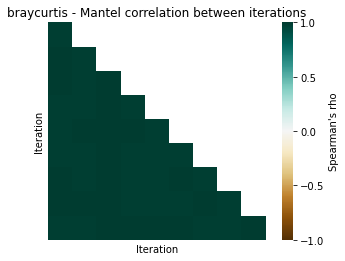

In [14]:
choices = ('matching', 'aitchison', 'euclidean', 'generalized_unifrac', 'canberra', 'russellrao', 'braycurtis', 'cosine', 'jensenshannon', 'yule', 'weighted_normalized_unifrac', 'unweighted_unifrac', 'hamming', 'weighted_unifrac', 'cityblock', 'sokalmichener', 'seuclidean', 'rogerstanimoto', 'correlation', 'minkowski', 'kulsinski', 'chebyshev', 'sqeuclidean', 'sokalsneath', 'jaccard', 'dice', 'canberra_adkins')
clustering_methods = ('nj', 'upgma')
correlation_methods = ('pearson', 'spearman')

sampling_depth = max(min_feature_count, 1)
metric = 'braycurtis'
clustering_method = clustering_methods[0]
correlation_method = correlation_methods[1]

beta_rar = beta_rarefaction(
    table = tabs,
    sampling_depth  = sampling_depth,
    metadata = metadata_qa,
    metric = metric,
    clustering_method = clustering_method,
    correlation_method = correlation_method,
)

 ## Beta diversity PCoA
 Ellipses represent 95% confidence intervals.

In [15]:
plot_tmp = f'{metric}-{clustering_method}-{correlation_method}-{sampling_depth}'
beta_rarefaction_view_path = os.path.join(qiime_folder, f'beta-rarefaction-{plot_tmp}.qzv')
beta_rar.visualization.save(beta_rarefaction_view_path)

beta_rar.visualization

<visualization: Visualization uuid: 02b23cab-34cd-46c0-a15c-32f78078dd25>